In [73]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from scipy.stats import fisher_exact
from sklearn.metrics.pairwise import cosine_similarity

In [74]:
# Load data
CELL_TYPES_FILE = "data/consolidated_cell_types.csv.gz"
CLASSIFICATION_FILE = "data/classification.csv.gz"
CONNECTIONS_FILE = "data/connections_princeton_no_threshold.csv.gz"

cell_types = pd.read_csv(CELL_TYPES_FILE)
classification = pd.read_csv(CLASSIFICATION_FILE)
connections = pd.read_csv(CONNECTIONS_FILE, low_memory=False)

threshold = 5

# Apply minimum synapse filter (threshold = 3)
connections = connections[connections['syn_count'] >= threshold]

print(f"Cell types: {cell_types.shape}, Classification: {classification.shape}, Connections: {connections.shape}")


Cell types: (137677, 3), Classification: (139255, 8), Connections: (3754052, 5)


In [75]:
# Merge the two metadata tables
cell_metadata = cell_types.merge(
    classification[["root_id", "super_class", "class", "sub_class"]],
    on="root_id",
    how="left"
)

print(cell_metadata.head())

              root_id primary_type additional_type(s) super_class  \
0  720575940596125868          T5c                NaN       optic   
1  720575940597856265         Tm16                NaN       optic   
2  720575940597944841          Tm7             CB3851       optic   
3  720575940598267657        TmY15                NaN       optic   
4  720575940599333574          Tm1                NaN       optic   

                  class         sub_class  
0  optic_lobe_intrinsic         t5_neuron  
1  optic_lobe_intrinsic    transmedullary  
2  optic_lobe_intrinsic    transmedullary  
3  optic_lobe_intrinsic  transmedullary_y  
4  optic_lobe_intrinsic    transmedullary  


In [76]:
# Define neurons of interest
neurons_of_interest = {
    "PAL02": {
        720575940628717585: "PAL02 Left",
        720575940620716897: "PAL02 Right",
    },
    "PAL04": {
        720575940632369439: "PAL04 Left",
        720575940636990064: "PAL04 Right",
    },
}

In [77]:
# Extract inputs per target neuron
def get_input_summary(connections, metadata, target_id):
    df = connections.loc[
        connections["post_root_id"] == target_id,
        ["pre_root_id", "syn_count"]
    ].rename(columns={"pre_root_id": "partner_id", "syn_count": "in_w"})

    df = df.merge(
        metadata[["root_id", "primary_type", "super_class"]],
        left_on="partner_id", right_on="root_id", how="left"
    ).drop(columns=["root_id"])
    return df

In [78]:
# Summarize by cell type and superclass
def summarize_inputs(df, category):
    g = df.groupby(category, as_index=False)["in_w"].sum()
    g["frac"] = g["in_w"] / g["in_w"].sum()
    return g.sort_values("frac", ascending=False, ignore_index=True)

In [79]:
# Iterate across neurons
results = {}

for group_name, neuron_dict in neurons_of_interest.items():
    group_res = []
    for target_id, target_label in neuron_dict.items():
        df_in = get_input_summary(connections, cell_metadata, target_id)
        df_primary = summarize_inputs(df_in, "primary_type")
        df_super = summarize_inputs(df_in, "super_class")
        group_res.append({"label": target_label,
                          "primary": df_primary, "super": df_super})
    results[group_name] = group_res


In [80]:
# Merge left/right hemispheres
def merge_left_right(res_list, level_key="super"):
    # Determine column name to merge on
    merge_col = "super_class" if level_key == "super" else "primary_type"

    left_df = res_list[0][level_key]
    right_df = res_list[1][level_key]

    m = left_df.merge(
        right_df, on=merge_col, how="outer", suffixes=("_L", "_R")
    ).fillna(0)

    m["mean_frac"] = (m["frac_L"] + m["frac_R"]) / 2
    m["mean_in_w"] = (m["in_w_L"] + m["in_w_R"]) / 2
    return m

In [81]:
# Plot composition per PAL type
def plot_input_composition(df, label, level):
    plt.figure(figsize=(6, 4))
    sns.barplot(y=df[level], x=df["mean_frac"], color="darkgreen")
    plt.xlabel("Fraction of total input")
    plt.ylabel(level.replace("_", " ").title())
    plt.title(f"Input composition by {level} for {label}\n(min. threshold: 5)")
    plt.tight_layout()

    os.makedirs("figures", exist_ok=True)
    fname = f"figures/input_composition_{label}_{level}.png".replace(" ", "_")
    plt.savefig(fname, dpi=300)
    print(f"Saved: {fname}")
    plt.show()

Saved: figures/input_composition_PAL02_super_class.png


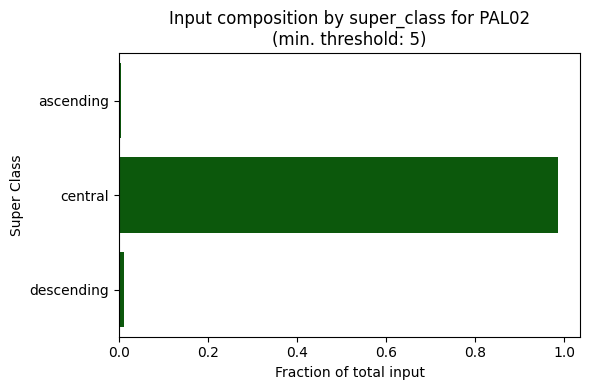

Saved: figures/input_composition_PAL02_primary_type.png


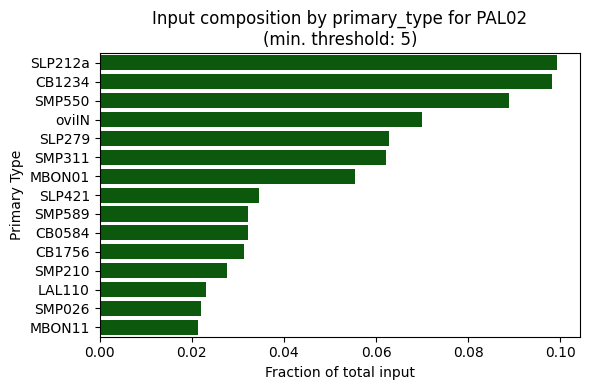

Saved: figures/input_composition_PAL04_super_class.png


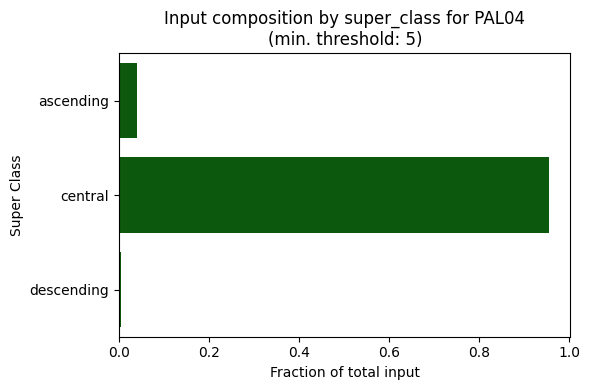

Saved: figures/input_composition_PAL04_primary_type.png


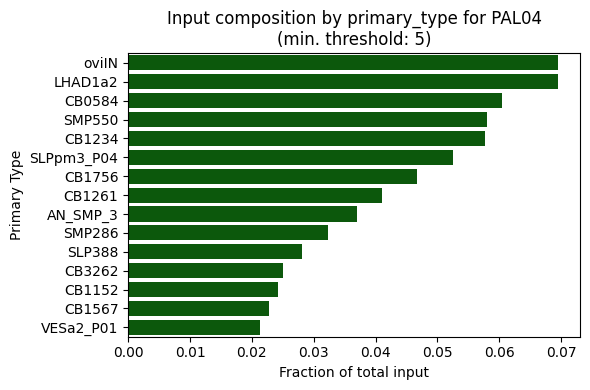

In [82]:
# Generate and compare PAL02 vs PAL04
for pal_type, res_list in results.items():
    merged_super = merge_left_right(res_list, "super")
    merged_primary = merge_left_right(res_list, "primary")

    merged_primary_sorted = merged_primary.sort_values("mean_frac", ascending=False, ignore_index=True)
    plot_input_composition(merged_super, pal_type, "super_class")
    plot_input_composition(merged_primary_sorted.head(15), pal_type, "primary_type")
